In [1]:
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow
import scipy.signal as sl
from typing import Optional
import scipy as sp
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout
from alltools.machine_learning.convtools import conviter
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.models import SimpleNetA
from deepmeg.params import compute_temporal_parameters,\
    compute_waveforms, compute_compression_parameters,\
    WaveForms, SpatialParameters, TemporalParameters, CompressionParameters

In [2]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False).crop(tmax=60)

In [3]:
events = mne.find_events(raw, stim_channel='STI 014')

In [4]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'face': 5, 'buttonpress': 32}
epochs = mne.Epochs(raw, events, tmin=-0.3, tmax=0.7, event_id=event_dict,
                    preload=True)

In [5]:
epochs.pick_types(meg='grad')

Number of events,85
Events,auditory/left: 20auditory/right: 20buttonpress: 4face: 4visual/left: 19visual/right: 18
Time range,-0.300 – 0.699 sec
Baseline,-0.300 – 0.000 sec


In [6]:
aud = epochs['auditory'].get_data()
aud_y = np.zeros_like(aud)
vis = epochs['visual'].get_data()
vis_y = np.ones_like(vis)
X = np.append(aud, vis, axis=0)
Y = np.append(aud_y, vis_y, axis=0)

In [60]:
aud.shape

(40, 376, 601)

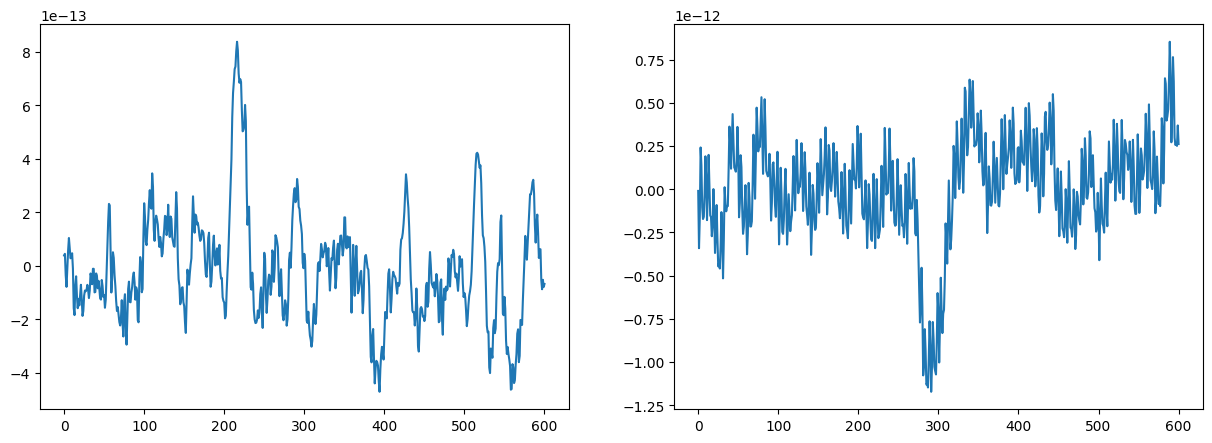

In [7]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(aud.mean((0, 1)))
ax2.plot(vis.mean((0, 1)))

In [8]:
#Specify import options
import_opt = dict(
    savepath='../TFR/',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 180),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((X, Y), **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X: (77, 203, 601) targets: (77, 203, 601)
(77, 203, 601)
Preprocessing:
Scaling to interval 0.0 - 180.0
n: 77
Splitting into: 6 folds x 12
Preprocessed: (77, 1, 421, 203) (77, 203, 601) folds: 6 x 12
Prepocessed sample shape: (1, 421, 203)
Target shape actual/metadata:  (2,) (2,)
Saving TFRecord# 0


In [9]:
lf_params = dict(
    n_latent=8, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.relu,#tf.keras.activations.linear,
    padding = 'SAME',
    pooling = 5,#5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3,
)

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 421, 203)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 421, 8)
Setting reg for fc, to l1
Built: fc input: (None, 1, 84, 8)
Input shape: (1, 421, 203)
y_pred: (None, 2)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 4s - loss: 0.0540 - cat_ACC: 0.9787 - val_loss: 0.0120 - val_cat_ACC: 1.0000 - 4s/epoch - 36ms/step
Epoch 2/25
100/100 - 2s - loss: 0.0018 - cat_ACC: 1.0000 - val_loss: 0.0072 - val_cat_ACC: 1.0000 - 2s/epoch - 17ms/step
Epoch 3/25
100/100 - 2s - loss: 8.1936e-04 - cat_ACC: 1.0000 - val_loss: 0.0053 - val_cat_ACC: 1.0000 - 2s/epoch - 20ms/step
Epoch 4/25
100/100 - 2s - loss: 5.0190e-04 - cat_ACC: 1.0000 - val_loss: 0.0041 - val_cat_ACC: 1.0000 - 2s/epoch - 19ms/step
Epoch 5/25
100/100 - 2s - loss: 3.2954e-04 - cat_ACC: 1.0000 - val_loss: 0.0034 - val_cat_ACC: 1.0000 - 2s/epoch - 17ms/step
Epoch 6/25
100/100 - 2s - loss: 2.2820e-04 - cat_ACC: 1.0000 - val_loss: 0.0030 - val_cat_ACC: 1.000

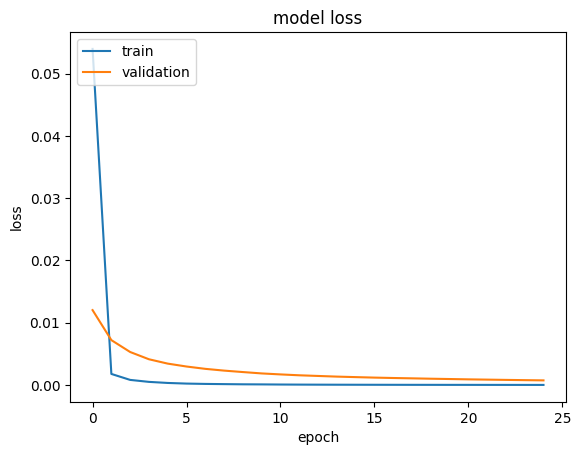

In [10]:
model = SimpleNetA(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [11]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

1.0

In [12]:
model.compute_patterns(meta['test_paths'])
nt = model.dataset.h_params['n_t']
time_courses = np.squeeze(model.lat_tcs.reshape([-1, model.specs['n_latent'], nt]))
time_courses = np.transpose(time_courses, (1, 0, 2))
time_courses_filt = np.squeeze(model.lat_tcs_filt.reshape([-1, model.specs['n_latent'], nt]))
time_courses_filt = np.transpose(time_courses_filt, (1, 0, 2))
times = (1 / float(model.dataset.h_params['fs'])) *\
    np.arange(model.dataset.h_params['n_t'])
patterns = model.patterns.copy()
model.compute_patterns(meta['test_paths'], output='filters', relevances=False)
filters = model.patterns.copy()
franges, finputs, foutputs, fresponces, fpatterns = compute_temporal_parameters(model)
induced, induced_filt, times, time_courses = compute_waveforms(model)
temp_relevance_loss, compression_weights = compute_compression_parameters(model)

order = model.branch_relevance_loss
wf = WaveForms(time_courses.mean(1), time_courses_filt.mean(1), induced, induced_filt, times, time_courses)
sp_ = SpatialParameters(patterns, filters)
tp = TemporalParameters(franges, finputs, foutputs, fresponces, fpatterns)
cp = CompressionParameters(
    temp_relevance_loss,
    compression_weights
)

Processing branch 0...	DONE
Processing branch 1...	DONE
Processing branch 2...	DONE
Processing branch 3...	DONE
Processing branch 4...	DONE
Processing branch 5...	DONE
Processing branch 6...	DONE
Processing branch 7...	DONE


In [14]:
from deepmeg.viz import plot_spatial_weights

In [41]:
time_courses = np.squeeze(model.lat_tcs.reshape([-1, model.specs['n_latent'], nt]))

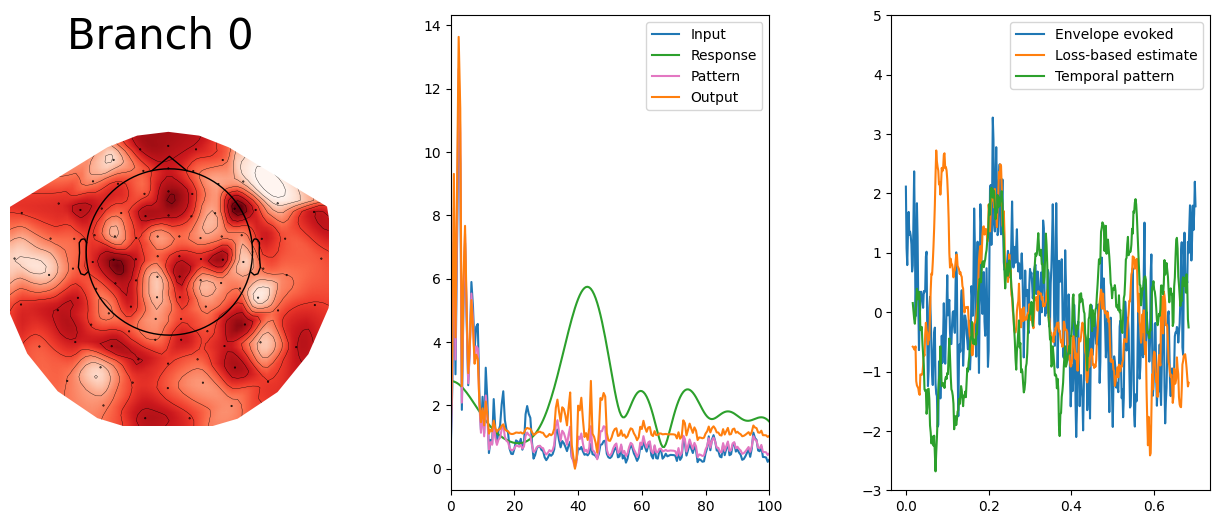

In [16]:
model.plot_branch(0, epochs.info, ['input', 'response', 'pattern', 'output'])

In [19]:
import scipy as sp
import mne
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib as mpl
import copy
import numpy as np
from typing import Optional, Union, NoReturn
from deepmeg.params import CompressionParameters, SpatialParameters, TemporalParameters, WaveForms, moving_average
from dataclasses import dataclass
from matplotlib.widgets import Button
from collections.abc import Iterable


def plot_patterns(
    patterns, info, order=None, axes=None, cmap='RdBu_r', sensors=True,
    colorbar=False, res=64,
    size=1, cbar_fmt='%3.1f', name_format='Latent\nSource %01d',
    show=True, show_names=False,
    outlines='head', contours=6,
    image_interp='linear'
) -> mpl.figure.Figure:
    if order is None:
        order = range(patterns.shape[1])
    info = copy.deepcopy(info)
    info.__setstate__(dict(_unlocked=True))
    info['sfreq'] = 1.
    patterns = mne.EvokedArray(patterns, info, tmin=0)
    return patterns.plot_topomap(
        times=order,
        axes=axes,
        cmap=cmap, colorbar=colorbar, res=res,
        cbar_fmt=cbar_fmt, sensors=sensors, units=None, time_unit='s',
        time_format=name_format, size=size, show_names=show_names,
        outlines=outlines,
        contours=contours, image_interp=image_interp, show=show)


def plot_spatial_weights(
    spatial_parameters: SpatialParameters,
    temporal_parameters: TemporalParameters,
    waveforms: WaveForms,
    info: mne.Info,
    compressions: Optional[CompressionParameters] = None,
    summarize: Optional[Union[str, list[float]]] = 'sum',
    title: Optional[str] = 'Spatial Patterns',
    temp_params: Optional[list[str]] = ['input', 'response', 'output'],
    show: Optional[bool] = True,
    logscale: Optional[bool] = False,
    shift_induced_times: Optional[bool | float] = False,
    filtered_induced: Optional[bool] = False
) -> Union[mp.figure.Figure, NoReturn]:

    mp.use('Qt5Agg')

    def init_canvas(ax01, ax02, ax1, ax2):
        ax01.axes.xaxis.set_visible(False)
        ax01.axes.yaxis.set_visible(False)
        ax02.axes.xaxis.set_visible(False)
        ax02.axes.yaxis.set_visible(False)

        ax01.spines['right'].set_visible(False)
        ax01.spines['left'].set_visible(False)
        ax01.spines['top'].set_visible(False)
        ax01.spines['bottom'].set_visible(False)
        ax02.spines['right'].set_visible(False)
        ax02.spines['left'].set_visible(False)
        ax02.spines['top'].set_visible(False)
        ax02.spines['bottom'].set_visible(False)

        ax1.spines['right'].set_visible(False)
        ax1.set_xlabel('Channels')
        ax1.set_ylabel('Latent Sources')
        ax1.spines['left'].set_alpha(0.2)
        ax1.spines['bottom'].set_alpha(0.2)
        ax1.spines['top'].set_alpha(0.2)
        ax1.axes.yaxis.set_alpha(0.2)
        ax1.set_yticks(np.arange(y_lim))
        ax1.set_yticklabels(labels=[i + 1 for i in sorting_callback.sorted_indices])
        ax1.tick_params(axis='both', which='both', length=5, color='#00000050')

        ax2.axes.yaxis.set_visible(False)
        ax2.axes.xaxis.set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['top'].set_alpha(0.2)
        ax2.spines['right'].set_alpha(0.2)
        ax2.spines['bottom'].set_alpha(0.2)

    class SortingCallback:

        def __init__(
            self,
            button: Button,
            fig: plt.Figure,
            bar_ax: mp.axes.Axes,
            imshow_ax: mp.axes.Axes,
            indices: list[int]
        ):
            self._button = button
            self._fig = fig
            self._bar_ax = bar_ax
            self._imshow_ax = imshow_ax
            self._event = None
            self._sorted_indices = indices

        def __call__(self, event):
            self._event = event

            if '▼' in self._button.label._text:
                self.decreasing()
            else:
                self.increasing()

        @property
        def sorted_indices(self):
            return self._sorted_indices

        @sorted_indices.setter
        def sorted_indices(self, value):
            raise AttributeError('Impossible to set indices directly')

        def increasing(self):
            self._button.label.set_text('Sort ▼')
            self._sorted_indices = sorted(range(len(sums)), key=lambda k: sums[k], reverse=True)
            self.update()

        def decreasing(self):
            self._button.label.set_text('Sort ▲')
            self._sorted_indices = sorted(range(len(sums)), key=lambda k: sums[k])
            self.update()

        def update(self):
            self._imshow_ax.clear()
            self._imshow_ax.imshow(data.T[self._sorted_indices, :], aspect='auto', cmap='RdBu_r')
            self._bar_ax.clear()
            self._bar_ax.barh(
                range(len(sums)),
                np.abs(sums)[self._sorted_indices], color=colors[self._sorted_indices],
                height=.9
            )
            init_canvas(ax01, ax02, ax1, ax2)
            self._fig.canvas.draw()

    def onclick(event):
        flim = 70
        crop = .05
        shift = shift_induced_times

        if ax1.lines:

            for i in range(len(ax1.lines)):
                ax1.lines.remove(ax1.lines[i])

        _, iy = event.xdata, event.ydata

        if (event.inaxes == ax1 or event.inaxes == ax2) \
            and event.xdata is not None \
            and event.ydata is not None \
            and 0 < event.xdata < x_lim \
                and -.5 < event.ydata < y_lim:
            iy = int(np.rint(iy))
            induced = waveforms.induced.copy()[
                sorting_callback.sorted_indices[iy],
                :flim,
                :
            ] if not filtered_induced else\
                waveforms.induced_filt.copy()[
                sorting_callback.sorted_indices[iy],
                :flim,
                :
            ]
            crop *= induced.shape[1] / 2

            for i, ind_course in enumerate(induced):
                induced[i] /= ind_course.mean()

            color = colors[sorting_callback._sorted_indices[iy]]
            line = mp.lines.Line2D([0, x_lim], [iy, iy], color=color, linewidth=2.56*data.shape[0]/data.shape[1], alpha=.4)
            ax1.add_line(line)
            fig1.canvas.draw()
            fig2 = plt.figure(constrained_layout=False)
            if compressions is None:
                gs2 = fig2.add_gridspec(
                    nrows=10,
                    ncols=3,
                    bottom=.1,
                    wspace=.05,
                    hspace=.1
                )
                ax21 = fig2.add_subplot(gs2[:, :-1])
                ax22 = fig2.add_subplot(gs2[0:5, -1])
                ax23 = fig2.add_subplot(gs2[5:, -1])
            else:
                gs2 = fig2.add_gridspec(
                    nrows=10,
                    ncols=16,
                    bottom=.1,
                    wspace=.05,
                    hspace=.1
                )
                ax21 = fig2.add_subplot(gs2[0:4, :-8])
                ax22 = fig2.add_subplot(gs2[0:5, -7:])
                ax23 = fig2.add_subplot(gs2[5:, -7:])
                ax24 = fig2.add_subplot(gs2[5:, :-9])

            plot_patterns(
                data,
                info,
                sorting_callback.sorted_indices[iy],
                ax21,
                name_format=''
            )
            ax22_t = ax22.twinx()
            evoked = waveforms.evoked[sorting_callback.sorted_indices[iy]] if not filtered_induced else\
                waveforms.evoked_filt[sorting_callback.sorted_indices[iy]]
            # ax22_t.plot(
            #     sp.stats.zscore(evoked),
            #     '#454545'
            # )
            pos = ax22.imshow(
                induced,
                cmap='RdBu_r',
                origin='lower'
            )
            cb = fig2.colorbar(
                pos,
                ax=ax22,
                pad=0.12,
                orientation='horizontal',
                aspect=75,
                fraction=.12
            )
            ax22.set_aspect('auto')
            ax22_t.set_aspect('auto')
            # ax22_t.set_ylim(top=1, bottom=-1)
            legend = list()
            for param in temp_params:
                match param:
                    case 'input':
                        legend.append('Filter input')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(temporal_parameters.finputs[sorting_callback.sorted_indices[iy]]),
                            color='tab:blue'
                        )
                    case 'output':
                        legend.append('Filter output')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(temporal_parameters.foutputs[sorting_callback.sorted_indices[iy]]),
                            color='tab:orange'
                        )
                    case 'response':
                        legend.append('Filter response')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(
                                temporal_parameters.fresponces[sorting_callback.sorted_indices[iy]]
                            ),
                            color='tab:green'
                        )
                    case 'pattern':
                        legend.append('Filtering pattern')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(
                                temporal_parameters.fpatterns[sorting_callback.sorted_indices[iy]]
                            ),
                            color='tab:pink'
                        )
                    case _:
                        raise NotImplementedError(f'Temporal parameter {param} is not implemented')

            ax22_t.set_ylabel('Amplitude', labelpad=12.5, rotation=270)
            ax22_t.spines['top'].set_alpha(.2)
            ax22_t.spines['right'].set_alpha(.2)
            ax22_t.spines['left'].set_alpha(.2)
            ax22_t.spines['bottom'].set_alpha(.2)
            ax22_t.tick_params(axis='both', which='both', length=5, color='#00000050')
            ax22.spines['top'].set_alpha(.2)
            ax22.spines['right'].set_alpha(.2)
            ax22.spines['left'].set_alpha(.2)
            ax22.spines['bottom'].set_alpha(.2)
            ax22.tick_params(axis='both', which='both', length=5, color='#00000050')
            cb.outline.set_color('#00000020')
            cb.ax.tick_params(axis='both', which='both', length=5, color='#00000050')
            times = np.unique(np.round(waveforms.times, 1))
            ranges = np.linspace(0, len(waveforms.times), len(times)).astype(int)

            if shift is True:
                times = np.round(times - times.mean(), 2)
            elif isinstance(shift, (int, float)):
                times = np.round(times - shift, 2)

            ax22.set_xticks(ranges)
            ax22.set_xticklabels(times)
            ax22.set_xlabel('Time (s)')
            ax22.set_ylabel('Frequency (Hz)')
            ax23.legend(legend, loc='upper right')
            ax23.spines['top'].set_alpha(.2)
            ax23.spines['right'].set_alpha(.2)
            ax23.spines['left'].set_alpha(.2)
            ax23.spines['bottom'].set_alpha(.2)
            ax23.tick_params(axis='both', which='both', length=5, color='#00000050')
            ax23.set_xlabel('Frequency (Hz)')
            ax23.set_ylabel('Amplitude (z-score)')
            # ax23.set_ylim(top=1.2)
            ax23.set_xlim([0, 70])
            ax22_t.set_xlim([2 * crop, len(waveforms.times) - 2 * crop])

            if logscale:
                ax23.set_yscale('log')

            if compressions:
                ax24.spines['top'].set_alpha(.2)
                ax24.spines['right'].set_alpha(.2)
                ax24.spines['left'].set_alpha(.2)
                ax24.spines['bottom'].set_alpha(.2)
                evo = sp.stats.zscore(waveforms.evoked_filt[sorting_callback.sorted_indices[iy]])
                ax24.plot(
                    evo# - evo.min()
                )
                loss_estimate = sp.stats.zscore(compressions.loss_estimate[sorting_callback.sorted_indices[iy]])
                kernel_size = 20
                loss_estimate = moving_average(loss_estimate - loss_estimate.min())
                # loss_estimate[kernel_size//2:-kernel_size//2] = loss_estimate[kernel_size//2:-kernel_size//2] - loss_estimate[kernel_size//2:-kernel_size//2].min()
                ax24.plot(
                    loss_estimate
                )
                ax24.set_xticks(ranges)
                ax24.set_xticklabels(times)
                ax24.set_xlabel('Time (s)')
                ax24.set_ylabel('Amplitude (z-score)')
                ax24.tick_params(axis='both', which='both', length=5, color='#00000050')
                ax24.legend(
                    [
                        'Filtered component evoked',
                        'Loss-based estimate'
                    ],
                    loc='upper right'
                )

            fig2.suptitle(f'Latent source {sorting_callback.sorted_indices[iy] + 1}')
            plt.show()

    data = spatial_parameters.patterns.copy()
    x_lim, y_lim = data.shape
    fig1 = plt.figure()
    fig1.suptitle(title)
    gs = fig1.add_gridspec(2, 2, hspace=0, wspace=0, width_ratios=[1, .1], height_ratios=[.025, 1])

    (ax01, ax02), (ax1, ax2) = gs.subplots(sharex='col', sharey='row')

    if summarize == 'sum':
        sums = np.sum(data, axis=0)
    elif summarize == 'sumabs':
        sums = np.sum(np.abs(data), axis=0)
    elif summarize == 'abssum':
        sums = np.abs(np.sum(data, axis=0))
    elif isinstance(summarize, Iterable) and len(summarize) == y_lim:
        sums = np.array(summarize)
    else:
        raise NotImplementedError(
            f'The "{summarize}" method not implemented. '
            'Available methods: "sum", "sumabs", "abssum"'
        )
    colors = np.array(['#f2827a' if sum_ >= 0 else '#8bbae5' for sum_ in sums])

    sort_button = Button(ax02, 'Sort')
    sorting_callback = SortingCallback(
        sort_button,
        fig1,
        ax2,
        ax1,
        sorted(range(len(sums)), reverse=False)
    )
    sort_button.on_clicked(sorting_callback)

    init_canvas(ax01, ax02, ax1, ax2)

    ax1.imshow(data.T, aspect='auto', cmap='RdBu_r')
    ax2.barh(sorting_callback.sorted_indices, np.abs(sums), color=colors, height=.9)

    cid1 = fig1.canvas.mpl_connect('button_press_event', onclick)
    cid2 = fig1.canvas.mpl_connect('close_event', lambda e: fig1.canvas.mpl_disconnect(cid1))

    if show:
        plt.show()

    fig1.canvas.mpl_disconnect(cid2)

    return fig1

/tmp/ipykernel_75663/2070434973.py:354: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if summarize == 'sum':
/tmp/ipykernel_75663/2070434973.py:356: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'sumabs':
/tmp/ipykernel_75663/2070434973.py:358: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'abssum':


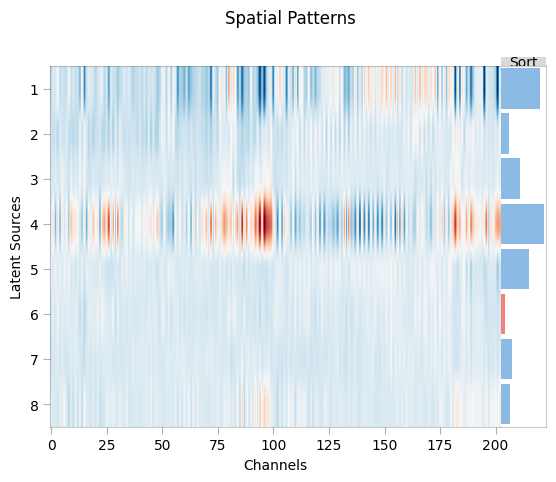

In [20]:
%matplotlib qt
plot_spatial_weights(
    sp_,
    tp,
    wf,
    epochs.info,
    cp,
    summarize=order,
    logscale=False,
    temp_params=['input', 'output', 'response', 'pattern'],
    # shift_induced_times = -epochs.times[0],
    filtered_induced=False
)